In [5]:
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
import string
import contractions
from nltk.corpus import stopwords

In [6]:
# join dfs
json_names = [str(x)+'_data.json' for x in [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]]
dfs = [pd.read_json('../scrapy/scrapy_eaforum/' + json_name) for json_name in json_names]
df = pd.concat(dfs)
df.head()

,date,title,author,num_comments,content
0,2013-06-21,Cheerfully,Julia_Wise,22 comments,"<div class=""PostsPage-postContent""><div><p>Whe..."
1,2013-05-13,What is effective altruism?,William_MacAskill,16 comments,"<div class=""PostsPage-postContent""><div><p><im..."
2,2013-11-05,A Long-run perspective on strategic cause sele...,Carl_Shulman,29 comments,"<div class=""PostsPage-postContent""><div><p><em..."
3,2013-08-19,Preventing human extinction,Peter_Singer,8 comments,"<div class=""PostsPage-postContent""><div><p><em..."
4,2013-05-27,A proposed adjustment to the astronomical wast...,Nick_Beckstead,1 comment,"<div class=""PostsPage-postContent""><div><p></p..."


In [7]:
df.isna().sum()

date            1
title           1
author          7
num_comments    1
content         1
dtype: int64

In [8]:
df = df[~df['content'].isna()]
df['author'] = df['author'].fillna('anonymous')

In [10]:
# remove recent posts
df = df[df['date']<'04-15-2020']

In [11]:
def extract_text(content):
    soup = BeautifulSoup(content, 'html.parser')
    #remove style tags:
    for tag in soup.find_all('style'):
        tag.replaceWith('')
    #remove all other tags
    text = soup.get_text()  
    #fix unicode
    text = unicodedata.normalize("NFKD", text)    
    #replace line breaks
    text = text.replace('\n', ' ')
    return text
    

In [12]:
df['content'] = df['content'].apply(extract_text)

In [13]:
df.head()

,date,title,author,num_comments,content
0,2013-06-21,Cheerfully,Julia_Wise,22 comments,"When I was younger, I was extremely struck by ..."
1,2013-05-13,What is effective altruism?,William_MacAskill,16 comments,Most forms of do-gooding start out with a Wh...
2,2013-11-05,A Long-run perspective on strategic cause sele...,Carl_Shulman,29 comments,Co-written by Nick Beckstead and Carl Shulman ...
3,2013-08-19,Preventing human extinction,Peter_Singer,8 comments,"Co-authored by Nick Beckstead, Peter Singer, a..."
4,2013-05-27,A proposed adjustment to the astronomical wast...,Nick_Beckstead,1 comment,An existential risk is a risk “that threatens...


In [14]:
df.to_pickle('../../data/ea_forum/all_year_df.pkl')

In [15]:
df['num_comments'] = df['num_comments'].str.replace(' comments', '').str.replace(' comment', '').str.replace('No', '0').astype(int)

In [16]:
df.sort_values(by='num_comments', ascending=False)

,date,title,author,num_comments,content
705,2019-04-23,Long-Term Future Fund: April 2019 grant recomm...,Habryka,240,Please note that the following grants are only...
14,2017-10-26,Why & How to Make Progress on Diversity & Incl...,Kelly_Witwicki,235,This post is a collection of potential solutio...
504,2019-11-15,"I'm Buck Shlegeris, I do research and outreach...",Buck,230,EDIT: I'm only going to answer a few more ques...
7,2016-10-24,Concerns with Intentional Insights,Jeff_Kaufman,186,A recent facebook post by Jeff Kaufman raised ...
622,2019-02-26,After one year of applying for EA jobs: It is ...,EA applicant,182,(I am writing this post under a pseudonym beca...
...,...,...,...,...,...
204,2014-11-05,Meetup : EA Brisbane Social Lunch,Joseph_ONeill,0,Discussion article for the meetup : EA Brisban...
70,2019-02-26,Oscar Horta: Promoting Welfare Biology as the ...,EA Global Transcripts,0,Content note: this transcript includes picture...
133,2014-05-29,Apples and oranges? Some initial thoughts on c...,Katja_Grace,0,An important part of effective altruism is com...
75,2019-03-01,Fireside Chat with Toby Ord (2018),EA Global Transcripts,0,Toby Ord is working on a book about existentia...


In [19]:
df.groupby('author')['num_comments'].sum().sort_values(ascending=False)

author
RyanCarey            1231
Peter_Hurford        1137
William_MacAskill     862
Milan_Griffes         789
kbog                  654
                     ... 
etaysom                 0
rosiecampbell           0
kdbscott                0
pmk                     0
MelissaMG               0
Name: num_comments, Length: 744, dtype: int32

In [17]:
(df.groupby('author')['num_comments'].sum()/df.groupby('author')['num_comments'].count()).sort_values(ascending=False)

author
EA applicant       182.0
Kelly_Witwicki     119.0
throwaway           96.0
Matthew_Barnett     82.0
AlyssaVance         80.0
                   ...  
Pigman               0.0
David_Goll           0.0
curiousepic          0.0
mattvdm              0.0
JDBauman             0.0
Name: num_comments, Length: 744, dtype: float64

In [20]:
all_text = df['content'].sum()

In [21]:
#expand contractions
all_text = ' '.join([contractions.fix(w) for w in all_text.split()])
# split into words
tokens = word_tokenize(all_text)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation
tokens = [w for w in tokens if w not in string.punctuation] 
# filter out stop words
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]

In [15]:
cleaned_text = ' '.join(tokens)

In [16]:
len(tokens)

2303326

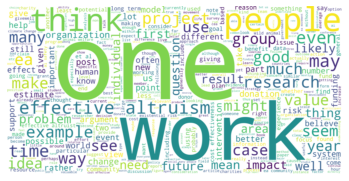

In [17]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white', width= 4000, height = 2000, max_words = 400).generate(cleaned_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
wordcloud.to_file('../../wordclouds/eaforum_wordcloud.jpg')